# Roadmap

In [1]:
%load_ext autoreload
%autoreload 2
import autoreload

## 1. Load data

In [2]:
from functions import load_data
data_df = load_data('data/time_series.xlsx')
data_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 292 entries, 2012-04-08 to 2017-11-05
Columns: 1833 entries, 012 to TRUHONE
dtypes: int64(1833)
memory usage: 4.1 MB


## 2. Train-Test Split

In [3]:
# splitting into training and testing sets setting aside last year for testing
from functions import ts_train_test_split

train_df, test_df = ts_train_test_split(data_df, 52)

Observations: 292
Training Observations: 240
Testing Observations: 52


In [ ]:
# DO NOT TOUCH Test Set!!!! Data snooping no-no

## 3. Segment Products

In [8]:
# make a list of column names
product_SKUs = list(train_df.columns.values)
len(product_SKUs)

1833

In [5]:
# non_active products
# defined as products that have not moved after a specified date

from product_segmentation_functions import identify_non_active

non_active = identify_non_active(train_df, product_SKUs, 2015, 11, 4)
len(non_active)

472

In [6]:
# new products 
from product_segmentation_functions import identify_new_product

new_products = identify_new_product(train_df, product_SKUs, 2015, 11, 4)
len(new_products)

138

In [9]:
# intermittent demand
from product_segmentation_functions import identify_intermittent_product
    
intermittent_demand = identify_intermittent_product(train_df, product_SKUs, non_active, 2015, 11, 4, 2)
len(intermittent_demand)

0

In [10]:
# products with very little demand
from product_segmentation_functions import identify_minute_demand
            
minute_demand = identify_minute_demand(train_df, product_SKUs, 30)
len(minute_demand)

681

In [11]:
# huge demand (over 3,000 units)

from product_segmentation_functions import identify_repackage_product
repackage_product = identify_repackage_product(train_df, product_SKUs, 3000)
len(repackage_product)

43

In [13]:
# create leftover dataset for dynamic time warping
from product_segmentation_functions import make_remainder_dataframe
products = make_remainder_dataframe(train_df, product_SKUs, non_active, new_products, minute_demand, repackage_product)
products.head()

,017,0300ST1550-1,0300ST320-1,0300ST365-1,0311HT245,0311HT265,0311HT320,0311HT450,0311PARCDU,0313013,...,9888,9895,9908,9920-1,9920-2,9920-3,9920-4,9920-5,9920-6,9920-7
EntDate,,,,,,,,,,,,,,,,,,,,,
2012-04-08,0,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,0,0,0
2012-04-15,0,0,0,1,0,2,0,2,4,0,...,105,2,3,21,20,19,7,166,98,0
2012-04-22,0,0,0,0,0,0,0,0,1,0,...,6,0,4,114,41,15,10,207,87,0
2012-04-29,0,0,0,200,0,200,0,0,31,0,...,-2,1,3,43,38,44,13,101,21,10
2012-05-06,0,0,0,0,3,0,0,0,4,0,...,40,0,2,154,29,47,21,75,43,0


## K-Means Clustering with Dynamic Time Warping Distance Measure

## Prepare products dataframe for time warping

In [14]:
# prepare products df for timewarping
from product_segmentation_functions import prep_dataframe_for_warping
data_arr = prep_dataframe_for_warping(products)

In [15]:
# timewarp!!!!

from ts_cluster import ts_cluster
import random
import numpy as np
from math import sqrt

cl_obj=ts_cluster(6)
cl_obj.k_means_clust(data_arr,10,4, progress=True)

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10


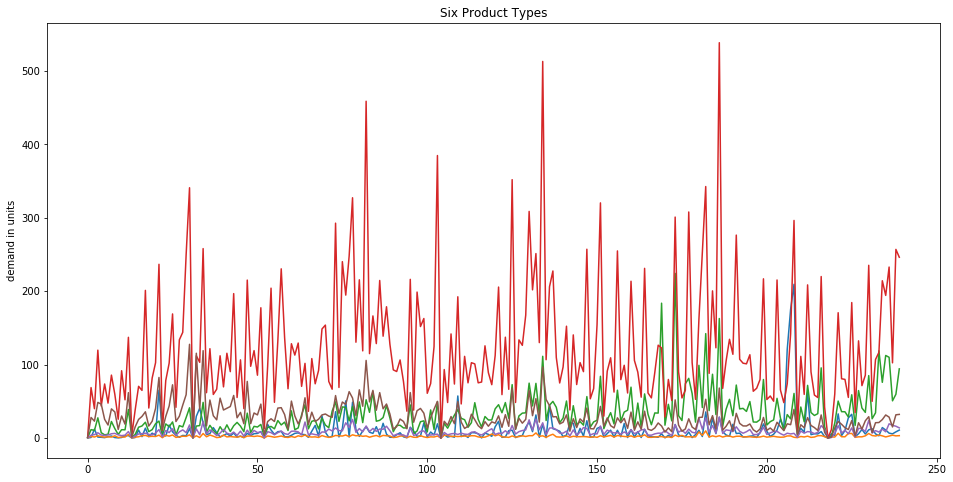

In [124]:
# plot it! save plot to send to Lee as an image
cl_obj.plot_centroids()

In [22]:
# save dictionary containing assignments
assigned_data = cl_obj.get_assignments()

In [28]:
# assign products to clusters
from product_segmentation_functions import assign_products

product_type0 = assign_products(products.T, assigned_data, 0)
product_type1 = assign_products(products.T, assigned_data, 1)
product_type2 = assign_products(products.T, assigned_data, 2)
product_type3 = assign_products(products.T, assigned_data, 3)
product_type4 = assign_products(products.T, assigned_data, 4)
product_type5 = assign_products(products.T, assigned_data, 5)
len(product_type0), len(product_type1), len(product_type2), len(product_type3), len(product_type4), len(product_type5)

(47, 309, 82, 70, 225, 139)

In [29]:
# save centroids
centroid0, centroid1, centroid2, centroid3, centroid4, centroid5 = cl_obj.get_centroids()

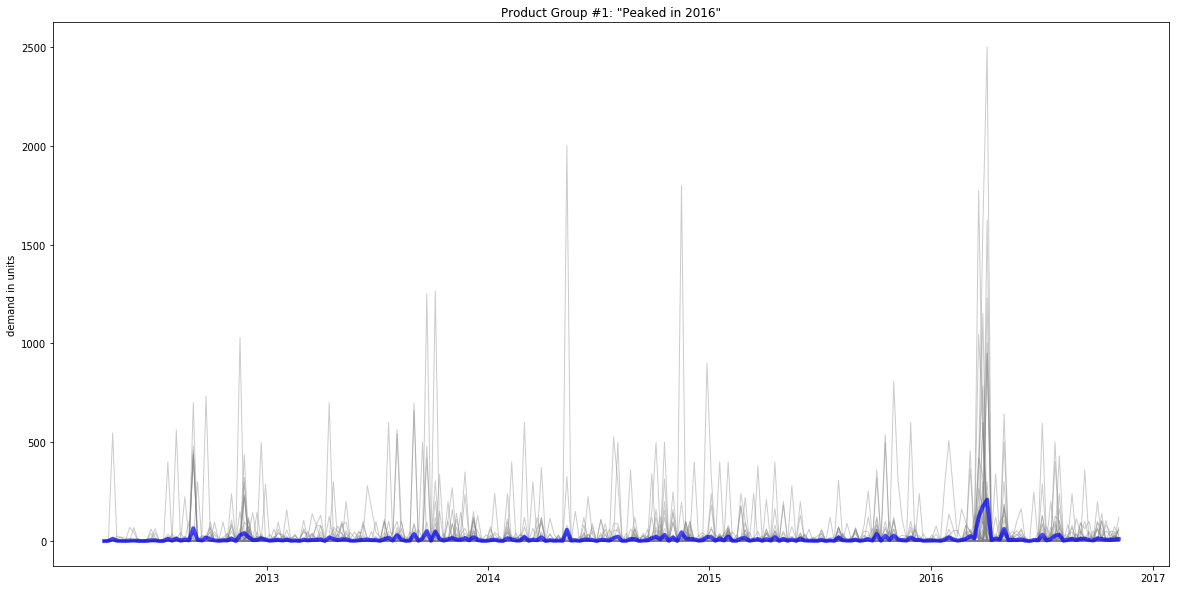

In [166]:
# product0
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Make a data frame of products
products_df = products.T
new_df = products_df[products_df.index.isin(product_type0)].T
col_names = new_df.columns.tolist()
new_df['centroid0'] = centroid0

plt.figure(figsize=(20,10))            
# multiple line plot
for col in col_names:
    plt.plot(new_df.index, new_df[col], marker='', color='grey', linewidth=1, alpha=0.4)

# plot centroid in different color
plt.plot(new_df.index, new_df['centroid0'], marker='', color='blue', linewidth=4, alpha=0.7)
plt.ylabel('demand in units')
#plt.xlabel()
plt.title('Product Group #1: "Peaked in 2016"')

plt.savefig('product_cluster0.png', dpi=300)
plt.show()

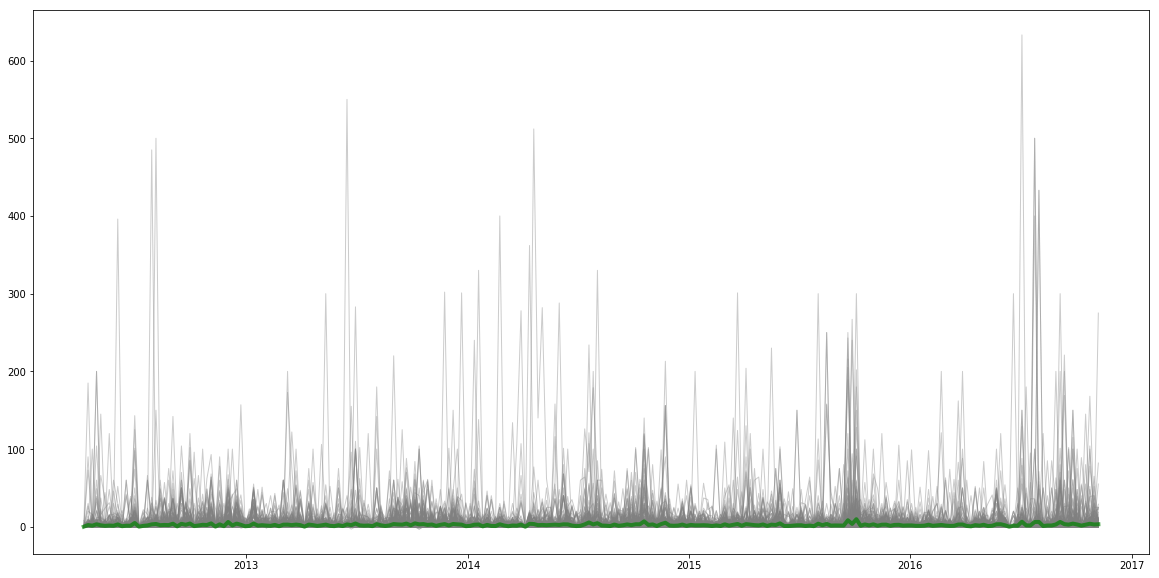

In [167]:
# product1
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Make a data frame of products
products_df = products.T
new_df = products_df[products_df.index.isin(product_type1)].T
col_names = new_df.columns.tolist()
new_df['centroid1'] = centroid1

plt.figure(figsize=(20,10))            
# multiple line plot
for col in col_names:
    plt.plot(new_df.index, new_df[col], marker='', color='grey', linewidth=1, alpha=0.4)

# plot centroid in different color
plt.plot(new_df.index, new_df['centroid1'], marker='', color='green', linewidth=4, alpha=0.7)

plt.savefig('product_cluster1.png', dpi=300)
plt.show()

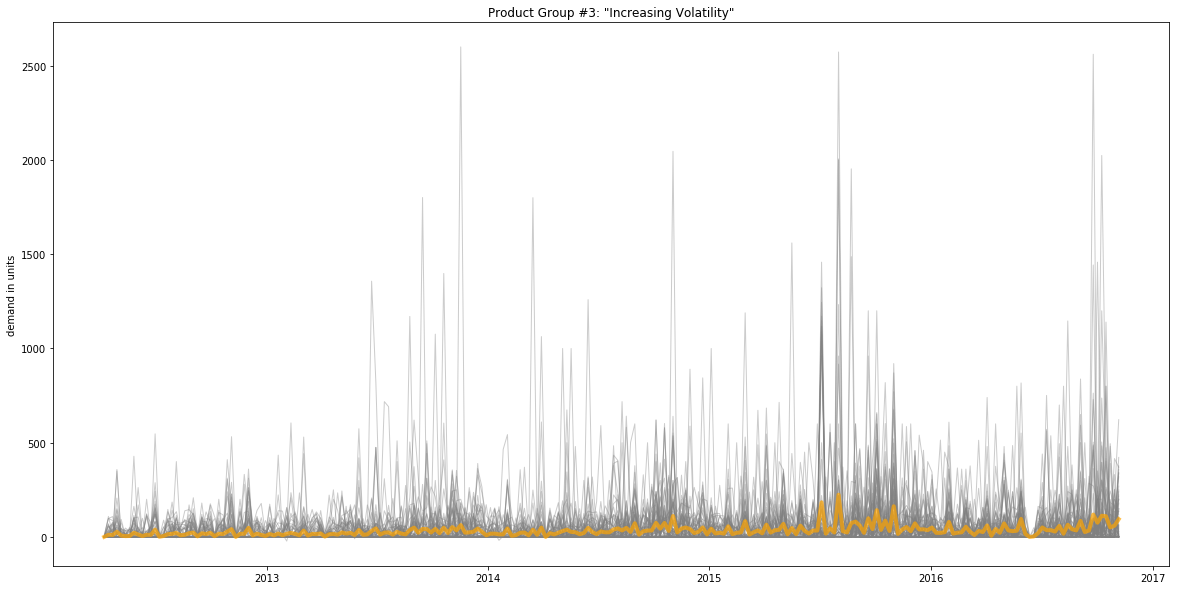

In [158]:
# Plot product clusters
# product2
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Make a data frame of products
products_df = products.T
new_df = products_df[products_df.index.isin(product_type2)].T
col_names = new_df.columns.tolist()
new_df['centroid2'] = centroid2

plt.figure(figsize=(20,10))            
# multiple line plot
for col in col_names:
    plt.plot(new_df.index, new_df[col], marker='', color='grey', linewidth=1, alpha=0.4)

# plot centroid in different color
plt.plot(new_df.index, new_df['centroid2'], marker='', color='orange', linewidth=4, alpha=0.7)
plt.ylabel('demand in units')
#plt.xlabel()
plt.title('Product Group #3: "Increasing Volatility"')

plt.savefig('product_cluster2.png', dpi=300)
plt.show()

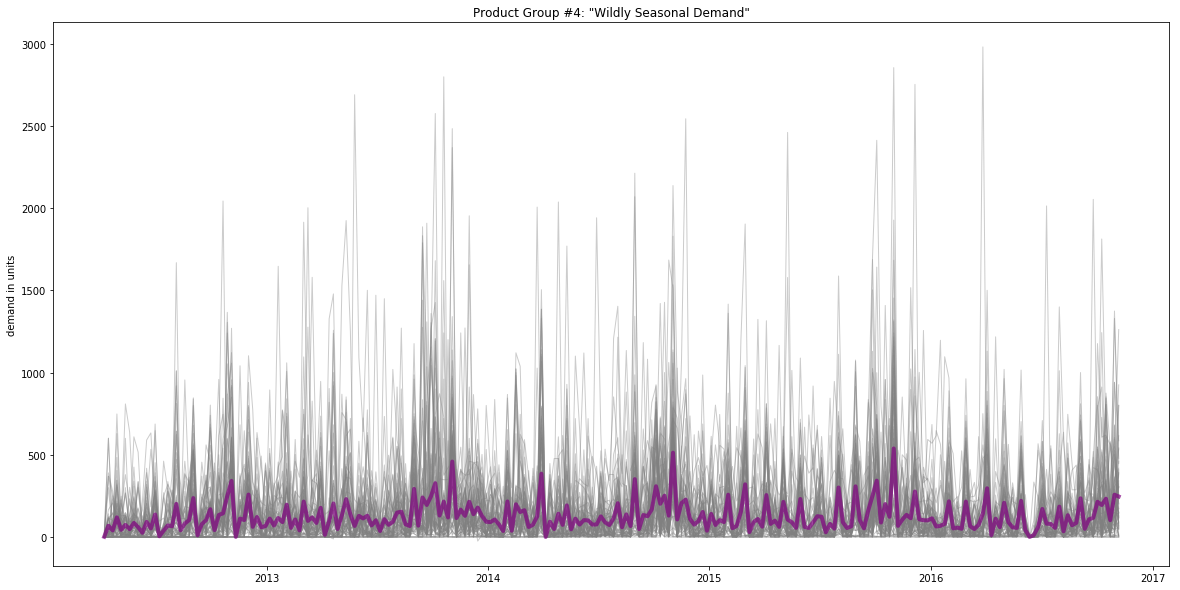

In [168]:
# Plot product clusters
# product3
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Make a data frame of products
products_df = products.T
new_df = products_df[products_df.index.isin(product_type3)].T
col_names = new_df.columns.tolist()
new_df['centroid3'] = centroid3

plt.figure(figsize=(20,10))            
# multiple line plot
for col in col_names:
    plt.plot(new_df.index, new_df[col], marker='', color='grey', linewidth=1, alpha=0.4)

# plot centroid in different color
plt.plot(new_df.index, new_df['centroid3'], marker='', color='purple', linewidth=4, alpha=0.7)
plt.ylabel('demand in units')
#plt.xlabel()
plt.title('Product Group #4: "Wildly Seasonal Demand"')

plt.savefig('product_cluster3.png', dpi=300)
plt.show()

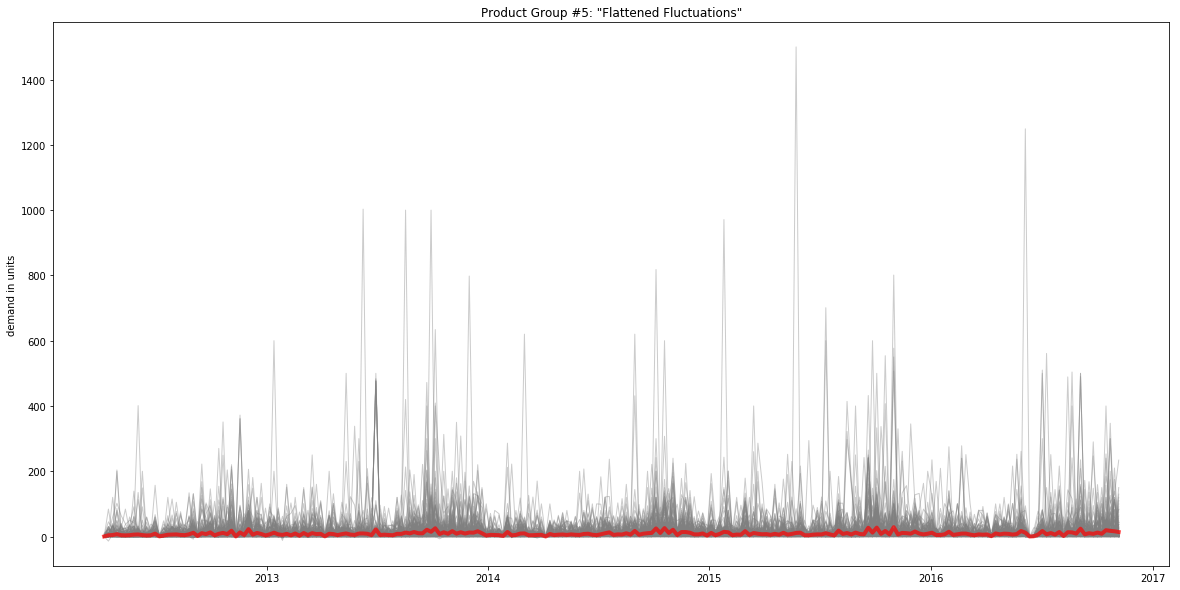

In [170]:
# product4
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Make a data frame of products
products_df = products.T
new_df = products_df[products_df.index.isin(product_type4)].T
col_names = new_df.columns.tolist()
new_df['centroid4'] = centroid4

plt.figure(figsize=(20,10))            
# multiple line plot
for col in col_names:
    plt.plot(new_df.index, new_df[col], marker='', color='grey', linewidth=1, alpha=0.4)

# plot centroid in different color
plt.plot(new_df.index, new_df['centroid4'], marker='', color='red', linewidth=4, alpha=0.7)
plt.ylabel('demand in units')
#plt.xlabel()
plt.title('Product Group #5: "Flattened Fluctuations"')

plt.savefig('product_cluster4.png', dpi=300)
plt.show()

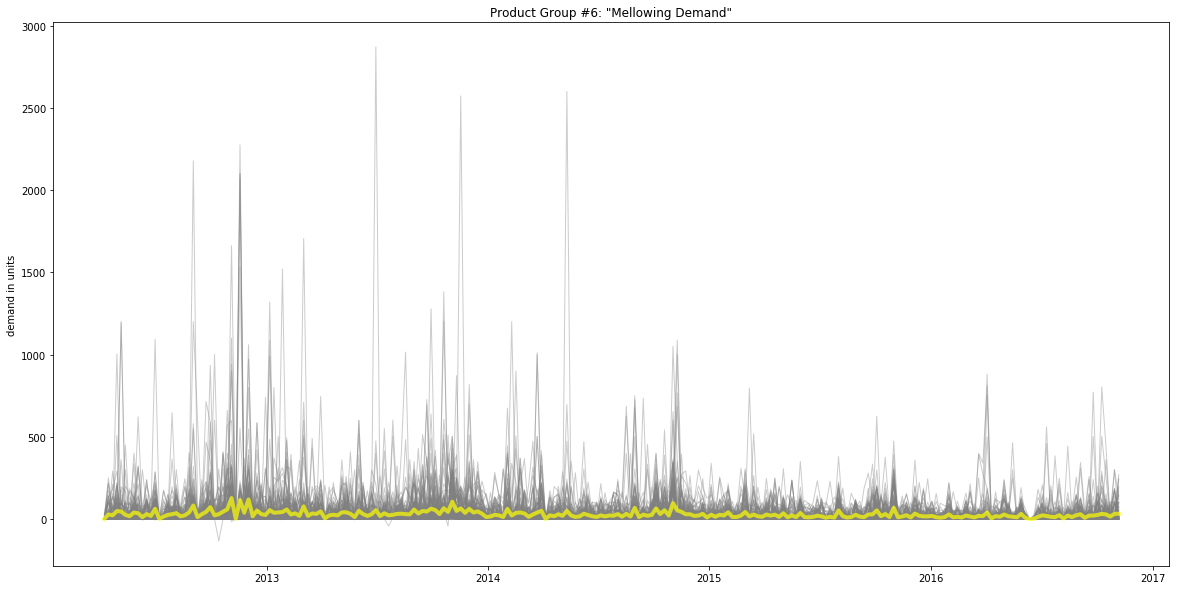

In [163]:
# product5
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Make a data frame of products
products_df = products.T
new_df = products_df[products_df.index.isin(product_type5)].T
col_names = new_df.columns.tolist()
new_df['centroid5'] = centroid5

plt.figure(figsize=(20,10))            
# multiple line plot
for col in col_names:
    plt.plot(new_df.index, new_df[col], marker='', color='grey', linewidth=1, alpha=0.4)

# plot centroid in different color
plt.plot(new_df.index, new_df['centroid5'], marker='', color='yellow', linewidth=4, alpha=0.7)
plt.ylabel('demand in units')
#plt.xlabel()
plt.title('Product Group #6: "Mellowing Demand"')

plt.savefig('product_cluster5.png', dpi=300)
plt.show()

In [174]:
dictionary = assigned_data
dataframe = products_df
key_n = 0
for key, value in dictionary.items():
    item = dataframe.index[x] for x in list(dictionary[key_n])
    print(item)

SyntaxError: invalid syntax (<ipython-input-174-073a8a4f57d5>, line 5)

In [ ]:
# make 
def add_labels_to_dataframe(dataframe, dictionary):
    for key, value in dictionary.items():
        for value in dataframe.index:
            dataframe.loc(value, label) = key
        return dataframe

# can evaluate k with Caliniski-Harabasz score
# passing df with X
X = dataframe.index
y = dataframe.label

from sklearn.metrics import calinski_harabaz_score()

CH_score = calinski_harabaz_score(X, labels)

Why bother? Let's look at item # 9920-2

In [154]:
# make a df to store all our predictions
from functions import make_copy_df
y_hat = make_copy_df(test_df, '9920-2')

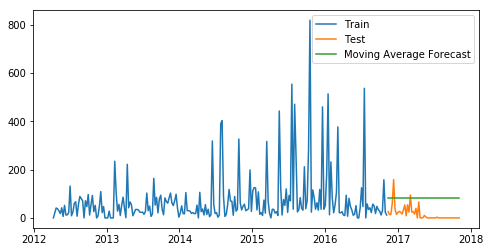

70.59469489094461

In [155]:
# baseline: Moving Average with 52
from functions import moving_average
from functions import plot_time_series
from functions import RMSE

y_hat['moving_avg'] = moving_average(train_df['9920-2'], m=52)

plot_time_series(train_df, test_df, '9920-2', y_hat, 'moving_avg', 'Moving Average Forecast')

RMSE(test_df,'9920-2', y_hat, 'moving_avg')

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/andreafabry/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


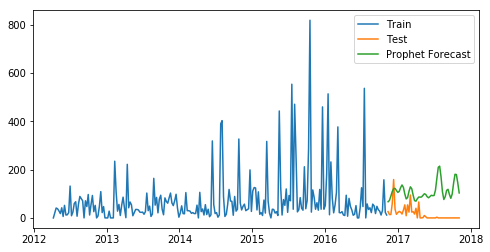

104.04466571337738

In [156]:
# FB Prophet
# imports 
from fbprophet import Prophet

# make a copy of the dataframe for Prophet transformations
from functions import make_copy_df
prophet_df = make_copy_df(train_df, '9920-2')

# rename variables (prophet requires the variable names in the time series to be
# y for target and ds for Datetime)
from functions import rename_columns
rename_columns(prophet_df, '9920-2')

# instantiate model instance and set the uncertainty interval to 95% 
# (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95, weekly_seasonality=True)
# fit
my_model.fit(prophet_df)
# forecast for a year
future_dates = my_model.make_future_dataframe(periods=52, freq='W')
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast = forecast.set_index('ds')
forecast_slice=forecast[240:292]
forecast_df = forecast_slice["yhat"]
# plot
plot_time_series(train_df, test_df, '9920-2', forecast_slice, 'yhat', 'Prophet Forecast')

RMSE(test_df, '9920-2', forecast_slice, 'yhat')

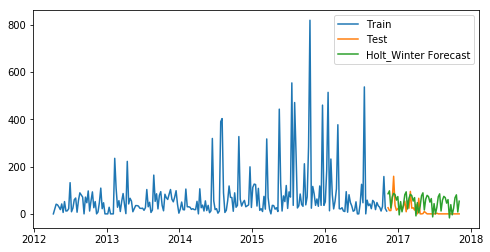

51.35384040458961

In [157]:
# Holt-Winters
# here we have trend and seasonality, so we will use Holt-Winters with Statsmodels
# additive trend and seasonality, no trend damping, seasonal periods=12
import numpy as np
from statsmodels.tsa.api import ExponentialSmoothing

fit1 = ExponentialSmoothing(np.asarray(train_df['9920-2']), seasonal_periods=12, 
                            trend='additive', seasonal='additive').fit(smoothing_level=0.51, 
                                                             smoothing_slope=0.015,
                                                             smoothing_seasonal=0.1)
y_hat['Holt_Winter'] = fit1.forecast(len(test_df))

# plot
plot_time_series(train_df, test_df, '9920-2', y_hat, 'Holt_Winter', 'Holt_Winter Forecast')

# calculate RMSE
RMSE(test_df,'9920-2', y_hat, 'Holt_Winter')

## 4. Forecast

### product_type0 (peak in 2016)

In [48]:
product_type0

['2000',
 '2265-100',
 '2708',
 '2887',
 '3911-7',
 '3922-7/23',
 '3950-7/23',
 '3966-7/09',
 '3966-7/12',
 '3982-7/24',
 '4039/12',
 '4069-100',
 '4095',
 '41144-7/14',
 '41214-7',
 '4135-7',
 '4139-7/16',
 '4400-7/16',
 '45021-7/23',
 '4506-7/20',
 '4521/16',
 '4521/20',
 '4532-7/14',
 '4562-7/14',
 '4571/20',
 '4572-7/12',
 '4572/16',
 '4578-7/17',
 '4581/16',
 '4582/16',
 '4589/16',
 '46101-7/16',
 '4878-7/18',
 '4907/23',
 '5502',
 '5558-G-100',
 '7261',
 '7267-1NL',
 '7310',
 '8052-2',
 '8410-17',
 '8702/6',
 '8731/5',
 '8744',
 '8872',
 '9508',
 '9920-4']

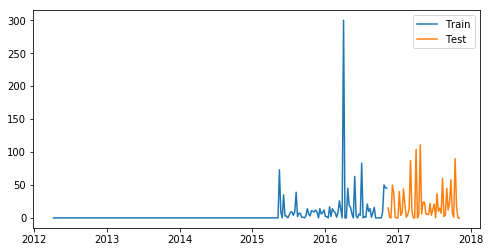

In [148]:
# plot one item
from functions import plot_train_test
plot_train_test(train_df, test_df, '4878-7/18')

In [150]:
# make a df to store all our predictions
from functions import make_copy_df
y_hat = make_copy_df(test_df, '4878-7/18')

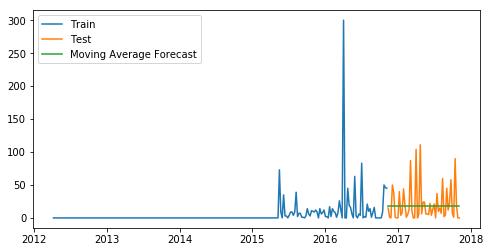

27.583895696133062

In [151]:
# baseline: Moving Average with 52
from functions import moving_average
from functions import plot_time_series
from functions import RMSE

y_hat['moving_avg'] = moving_average(train_df['4878-7/18'], m=52)

plot_time_series(train_df, test_df, '4878-7/18', y_hat, 'moving_avg', 'Moving Average Forecast')

RMSE(test_df,'4878-7/18', y_hat, 'moving_avg')

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/andreafabry/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


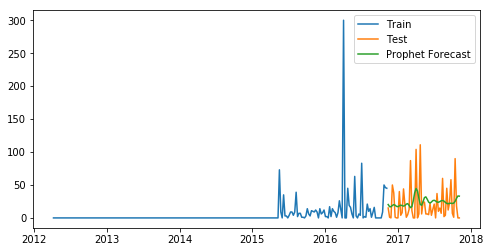

28.15442279709474

In [152]:
# FB Prophet
# imports 
from fbprophet import Prophet

# make a copy of the dataframe for Prophet transformations
from functions import make_copy_df
prophet_df = make_copy_df(train_df, '4878-7/18')

# rename variables (prophet requires the variable names in the time series to be
# y for target and ds for Datetime)
from functions import rename_columns
rename_columns(prophet_df, '4878-7/18')

# instantiate model instance and set the uncertainty interval to 95% 
# (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95, weekly_seasonality=True)
# fit
my_model.fit(prophet_df)
# forecast for a year
future_dates = my_model.make_future_dataframe(periods=52, freq='W')
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast = forecast.set_index('ds')
forecast_slice=forecast[240:292]
forecast_df = forecast_slice["yhat"]
# plot
plot_time_series(train_df, test_df, '4878-7/18', forecast_slice, 'yhat', 'Prophet Forecast')

RMSE(test_df, '4878-7/18', forecast_slice, 'yhat')

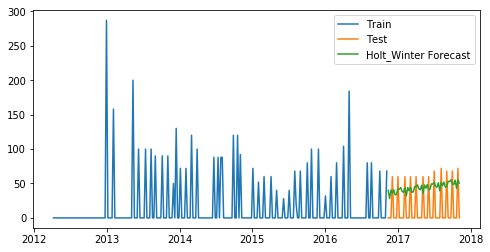

39.944613205014086

In [69]:
# Holt-Winters
# here we have trend and seasonality, so we will use Holt-Winters with Statsmodels
# additive trend and seasonality, no trend damping, seasonal periods=12
import numpy as np
from statsmodels.tsa.api import ExponentialSmoothing

fit1 = ExponentialSmoothing(np.asarray(train_df['8410-17']), seasonal_periods=12, 
                            trend='additive', seasonal='additive').fit(smoothing_level=0.51, 
                                                             smoothing_slope=0.015,
                                                             smoothing_seasonal=0.1)
y_hat['Holt_Winter'] = fit1.forecast(len(test_df))

# plot
plot_time_series(train_df, test_df, '8410-17', y_hat, 'Holt_Winter', 'Holt_Winter Forecast')

# calculate RMSE
RMSE(test_df,'8410-17', y_hat, 'Holt_Winter')

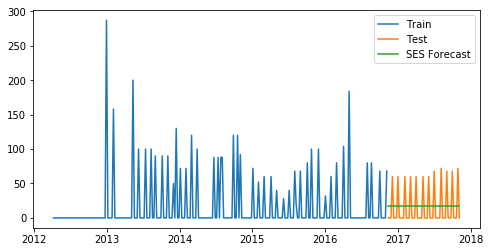

27.164006469354025

In [104]:
# Simple Exponential Smoothing
from statsmodels.tsa.api import SimpleExpSmoothing

fit2 = SimpleExpSmoothing(np.asarray(train_df['8410-17'])).fit(smoothing_level=0.1,optimized=False)
y_hat['SES'] = fit2.forecast(len(test_df))

# plot
plot_time_series(train_df, test_df, '8410-17', y_hat, 'SES', 'SES Forecast')

# calculate RMSE
RMSE(test_df,'8410-17', y_hat, 'SES')

In [67]:
# SARIMA
# gridsearch with pyramid
from pyramid.arima import ARIMA

fit = ARIMA(order=(1, 1, 0), seasonal_order=(1, 0, 0, 12)).fit(y=train_df['8410-17'])

from pyramid.arima import auto_arima

stepwise_fit = auto_arima(train_df['8410-17'], start_p=0, start_q=0, max_p=6, max_q=6, m=12,
                          start_P=0, seasonal=True, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=2558.219, BIC=2568.494, Fit time=0.318 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=2690.771, BIC=2697.621, Fit time=0.019 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=2573.759, BIC=2587.459, Fit time=0.275 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2380.239, BIC=2393.939, Fit time=0.303 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=2382.218, BIC=2399.342, Fit time=0.410 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=2501.814, BIC=2512.089, Fit time=0.149 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=2382.230, BIC=2399.355, Fit time=0.880 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=2381.536, BIC=2402.085, Fit time=3.454 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2376.943, BIC=2394.068, Fit time=0.458 seconds
Fit ARIMA: order=(1, 1, 0) s

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  240
Model:             SARIMAX(2, 1, 4)x(0, 1, 1, 12)   Log Likelihood               -1173.701
Date:                            Mon, 04 Jun 2018   AIC                           2365.402
Time:                                    12:50:24   BIC                           2396.227
Sample:                                         0   HQIC                          2377.840
                                            - 240                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0446      0.029     -1.552      0.121      -0.101       0.012
ar.L1          0.2348      0.018     13.249      0.000       0.200       0.270
ar.L2         -0.9990      0.008   -123.042      0.000      -1.015      -0.983
ma.L1         -1.4324     11.373     -0.126      0.900     -23.724      20.859
ma.L2          1.4748      4.882      0.302      0.763      -8.093      11.043
ma.L3         -1.2522     11.825     -0.106      0.916     -24.429      21.924
ma.L4          0.2099      2.363      0.089      0.929      -4.422       4.842
ma.S.L12      -0.9932      1.276     -0.778      0.436      -3.494       1.508
sigma2      1458.6077   1.63e+04      0.089      0.929   -3.06e+04    3.35e+04
===================================================================================
Ljung-Box (Q):                       26.31   Jarque-Bera (JB):               829.46
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                             2.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/Users/andreafabry/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


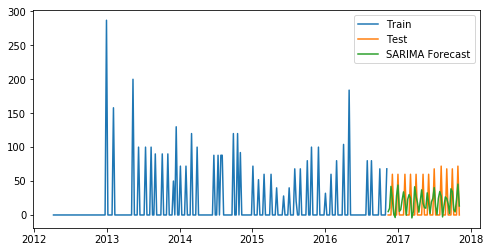

25.20095995660667

In [68]:
# fit with SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX

fit1 = SARIMAX(train_df['8410-17'], order=(2, 1, 4), seasonal_order=(0,1,2,12), freq='W').fit()
y_hat['SARIMA'] = fit1.predict(start="2016-11-06", end="2017-11-05", dynamic=True, typ='levels')

# plot
plot_time_series(train_df, test_df, '8410-17', y_hat, 'SARIMA', 'SARIMA Forecast')

# calculate RMSE

RMSE(test_df,'8410-17', y_hat, 'SARIMA')

#### another product from product_type0

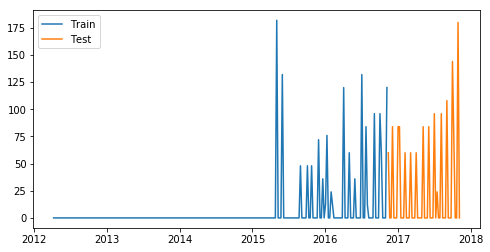

In [56]:
plot_train_test(train_df, test_df, '8731/5')

In [70]:
# make a df to store all our predictions
from functions import make_copy_df
y_hat = make_copy_df(test_df, '8731/5')

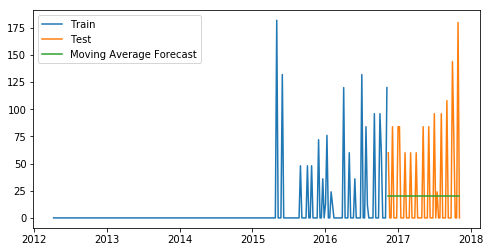

44.75485907968657

In [71]:
# baseline: Moving Average with 52
from functions import moving_average
from functions import plot_time_series
from functions import RMSE

y_hat['moving_avg'] = moving_average(train_df['8731/5'], m=52)

plot_time_series(train_df, test_df, '8731/5', y_hat, 'moving_avg', 'Moving Average Forecast')

RMSE(test_df,'8731/5', y_hat, 'moving_avg')

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/andreafabry/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


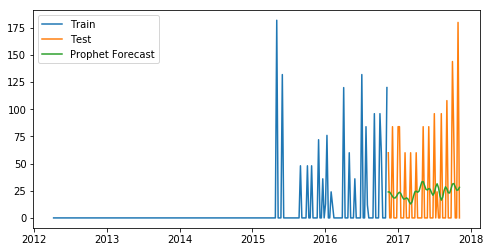

43.99671204139942

In [73]:
# FB Prophet
# imports 
from fbprophet import Prophet

# make a copy of the dataframe for Prophet transformations
from functions import make_copy_df
prophet_df = make_copy_df(train_df, '8731/5')

# rename variables (prophet requires the variable names in the time series to be
# y for target and ds for Datetime)
from functions import rename_columns
rename_columns(prophet_df, '8731/5')

# instantiate model instance and set the uncertainty interval to 95% 
# (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95, weekly_seasonality=True)
# fit
my_model.fit(prophet_df)
# forecast for a year
future_dates = my_model.make_future_dataframe(periods=52, freq='W')
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast = forecast.set_index('ds')
forecast_slice=forecast[240:292]
forecast_df = forecast_slice["yhat"]
# plot
plot_time_series(train_df, test_df, '8731/5', forecast_slice, 'yhat', 'Prophet Forecast')

RMSE(test_df, '8731/5', forecast_slice, 'yhat')

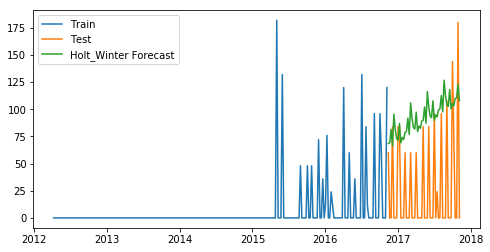

79.99944939776836

In [72]:
# Holt-Winters
# here we have trend and seasonality, so we will use Holt-Winters with Statsmodels
# additive trend and seasonality, no trend damping, seasonal periods=12
import numpy as np
from statsmodels.tsa.api import ExponentialSmoothing

fit1 = ExponentialSmoothing(np.asarray(train_df['8731/5']), seasonal_periods=12, 
                            trend='additive', seasonal='additive').fit(smoothing_level=0.51, 
                                                             smoothing_slope=0.015,
                                                             smoothing_seasonal=0.1)
y_hat['Holt_Winter'] = fit1.forecast(len(test_df))

# plot
plot_time_series(train_df, test_df, '8731/5', y_hat, 'Holt_Winter', 'Holt_Winter Forecast')

# calculate RMSE
RMSE(test_df,'8731/5', y_hat, 'Holt_Winter')

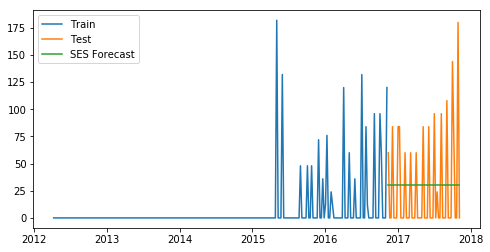

44.494835953798

In [105]:
# Simple Exponential Smoothing
from statsmodels.tsa.api import SimpleExpSmoothing

fit2 = SimpleExpSmoothing(np.asarray(train_df['8731/5'])).fit(smoothing_level=0.1,optimized=False)
y_hat['SES'] = fit2.forecast(len(test_df))

# plot
plot_time_series(train_df, test_df, '8731/5', y_hat, 'SES', 'SES Forecast')

# calculate RMSE
RMSE(test_df,'8731/5', y_hat, 'SES')

In [74]:
# SARIMA
# gridsearch with pyramid
from pyramid.arima import ARIMA

fit = ARIMA(order=(1, 1, 0), seasonal_order=(1, 0, 0, 12)).fit(y=train_df['8731/5'])

from pyramid.arima import auto_arima

stepwise_fit = auto_arima(train_df['8731/5'], start_p=0, start_q=0, max_p=6, max_q=6, m=12,
                          start_P=0, seasonal=True, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=2414.010, BIC=2420.860, Fit time=0.015 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=2313.564, BIC=2327.264, Fit time=0.341 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=2343.849, BIC=2354.124, Fit time=0.058 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=2256.022, BIC=2273.147, Fit time=0.843 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=2209.191, BIC=2229.741, Fit time=1.975 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=2261.751, BIC=2278.876, Fit time=1.650 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=2177.741, BIC=2201.715, Fit time=3.086 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(2, 1, 1, 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  240
Model:             SARIMAX(5, 1, 1)x(2, 1, 1, 12)   Log Likelihood               -1031.119
Date:                            Mon, 04 Jun 2018   AIC                           2084.237
Time:                                    13:01:43   BIC                           2121.912
Sample:                                         0   HQIC                          2099.439
                                            - 240                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0352      0.014      2.462      0.014       0.007       0.063
ar.L1         -0.1833      0.069     -2.655      0.008      -0.319      -0.048
ar.L2         -0.1879      0.077     -2.448      0.014      -0.338      -0.037
ar.L3         -0.0510      0.069     -0.737      0.461      -0.187       0.085
ar.L4          0.2180      0.041      5.332      0.000       0.138       0.298
ar.L5          0.1559      0.057      2.753      0.006       0.045       0.267
ma.L1         -0.9938      0.084    -11.796      0.000      -1.159      -0.829
ar.S.L12      -0.2246      0.094     -2.392      0.017      -0.409      -0.041
ar.S.L24      -0.2850      0.088     -3.237      0.001      -0.458      -0.112
ma.S.L12      -0.7475      0.064    -11.755      0.000      -0.872      -0.623
sigma2       456.6436     39.482     11.566      0.000     379.261     534.026
===================================================================================
Ljung-Box (Q):                       49.98   Jarque-Bera (JB):              5599.09
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):            1713.13   Skew:                             3.63
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

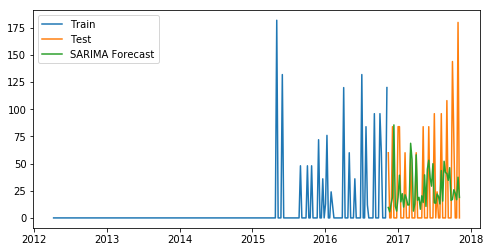

44.89750780354106

In [75]:
# fit with SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX

fit1 = SARIMAX(train_df['8731/5'], order=(5, 1, 1), seasonal_order=(2,1,2,12), freq='W').fit()
y_hat['SARIMA'] = fit1.predict(start="2016-11-06", end="2017-11-05", dynamic=True, typ='levels')

# plot
plot_time_series(train_df, test_df, '8731/5', y_hat, 'SARIMA', 'SARIMA Forecast')

# calculate RMSE

RMSE(test_df,'8731/5', y_hat, 'SARIMA')

### product_type0 (peak in 2016)

In [76]:
product_type3

['1550',
 '1777',
 '2036',
 '2801-7',
 '2898',
 '2911',
 '2927-7',
 '2933',
 '4022-7',
 '4040-7/09',
 '4042-7',
 '4045-7',
 '4050-7',
 '4060-7',
 '4066-7/12',
 '4066/09',
 '4067-7/10',
 '4086-7/09',
 '4103-7',
 '4105-7',
 '4107-7',
 '4109-7',
 '4110-7',
 '4126-7',
 '4128-7',
 '41284-7',
 '4143-7',
 '4152-7/23',
 '4172-7',
 '4176-7',
 '4188-7',
 '4188-7/14',
 '4192-7',
 '4193-7',
 '4473',
 '4474/26',
 '4522-7/16',
 '4524-7/23',
 '4560-7/20',
 '4562-7/16',
 '4562-7/20',
 '4584-7/16',
 '4596-7/16',
 '4596-7/20',
 '4602-7',
 '4680/16',
 '4851-7/09',
 '4860-7',
 '4862-7/20',
 '4862-7/26',
 '7228/35',
 '7267-17',
 '8000',
 '8008',
 '8305',
 '8347',
 '8748',
 '8758-1',
 '8777',
 '8944-1',
 '9310',
 '9395',
 '9634',
 '9704',
 '9727',
 '9728',
 '9731',
 '9755',
 '9920-1',
 '9920-5']

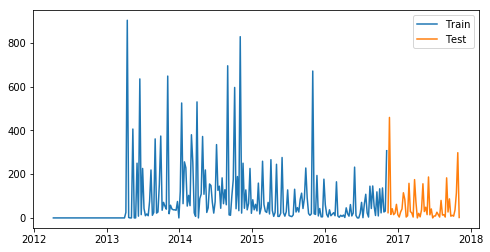

In [77]:
# plot one item
from functions import plot_train_test
plot_train_test(train_df, test_df, '4067-7/10')

In [79]:
# make a df to store all our predictions
from functions import make_copy_df
y_hat = make_copy_df(test_df, '4067-7/10')

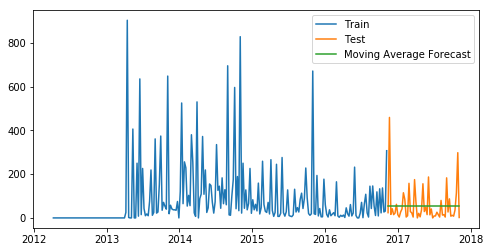

83.31835688895067

In [80]:
# baseline: Moving Average with 52
from functions import moving_average
from functions import plot_time_series
from functions import RMSE

y_hat['moving_avg'] = moving_average(train_df['4067-7/10'], m=52)

plot_time_series(train_df, test_df, '4067-7/10', y_hat, 'moving_avg', 'Moving Average Forecast')

RMSE(test_df,'4067-7/10', y_hat, 'moving_avg')

In [87]:
# SARIMA
# gridsearch with pyramid
from pyramid.arima import ARIMA

fit = ARIMA(order=(1, 1, 0), seasonal_order=(1, 0, 0, 12)).fit(y=train_df['4067-7/10'])

from pyramid.arima import auto_arima

stepwise_fit = auto_arima(train_df['4067-7/10'], start_p=0, start_q=0, max_p=6, max_q=6, m=12,
                          start_P=0, seasonal=True, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=3118.684, BIC=3128.959, Fit time=0.279 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=3263.424, BIC=3270.274, Fit time=0.015 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=3115.053, BIC=3128.753, Fit time=0.329 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2942.069, BIC=2955.769, Fit time=0.700 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=2945.162, BIC=2962.286, Fit time=0.950 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=3072.888, BIC=3083.163, Fit time=0.086 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=2945.137, BIC=2962.262, Fit time=1.791 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=2947.465, BIC=2968.015, Fit time=1.452 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2936.253, BIC=2953.378, Fit time=0.944 seconds
Fit ARIMA: order=(1, 1, 0) s

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  240
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1463.126
Date:                            Mon, 04 Jun 2018   AIC                           2936.253
Time:                                    13:20:14   BIC                           2953.378
Sample:                                         0   HQIC                          2943.163
                                            - 240                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1950      0.207     -0.944      0.345      -0.600       0.210
ar.L1         -0.1965      0.102     -1.926      0.054      -0.397       0.003
ma.L1         -0.9307      0.034    -27.479      0.000      -0.997      -0.864
ma.S.L12      -0.9927      1.182     -0.840      0.401      -3.309       1.324
sigma2      1.976e+04    2.3e+04      0.860      0.390   -2.53e+04    6.48e+04
===================================================================================
Ljung-Box (Q):                       84.80   Jarque-Bera (JB):               865.62
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             2.35
Prob(H) (two-sided):                  0.01   Kurtosis:                        11.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

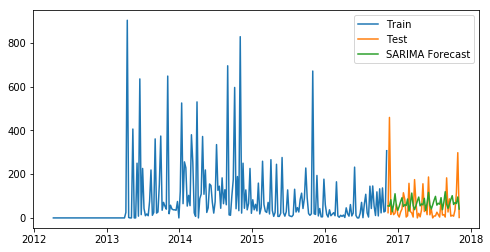

88.25479555093283

In [88]:
# fit with SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX

fit1 = SARIMAX(train_df['4067-7/10'], order=(1, 1, 1), seasonal_order=(0,1,1,12), freq='W').fit()
y_hat['SARIMA'] = fit1.predict(start="2016-11-06", end="2017-11-05", dynamic=True, typ='levels')

# plot
plot_time_series(train_df, test_df, '4067-7/10', y_hat, 'SARIMA', 'SARIMA Forecast')

# calculate RMSE

RMSE(test_df,'4067-7/10', y_hat, 'SARIMA')

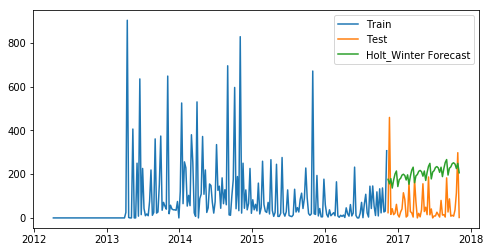

175.47626434736614

In [86]:
# Holt-Winters
# here we have trend and seasonality, so we will use Holt-Winters with Statsmodels
# additive trend and seasonality, no trend damping, seasonal periods=12
import numpy as np
from statsmodels.tsa.api import ExponentialSmoothing

fit1 = ExponentialSmoothing(np.asarray(train_df['4067-7/10']), seasonal_periods=12, 
                            trend='additive', seasonal='additive').fit(smoothing_level=0.51, 
                                                             smoothing_slope=0.015,
                                                             smoothing_seasonal=0.1)
y_hat['Holt_Winter'] = fit1.forecast(len(test_df))

# plot
plot_time_series(train_df, test_df, '4067-7/10', y_hat, 'Holt_Winter', 'Holt_Winter Forecast')

# calculate RMSE
RMSE(test_df,'4067-7/10', y_hat, 'Holt_Winter')

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/andreafabry/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


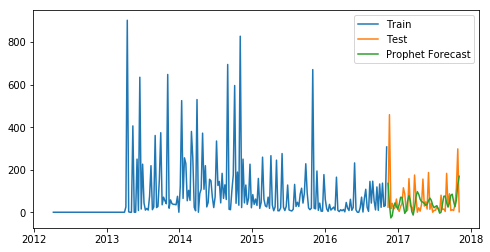

89.00384674011642

In [84]:
# FB Prophet
# imports 
from fbprophet import Prophet

# make a copy of the dataframe for Prophet transformations
from functions import make_copy_df
prophet_df = make_copy_df(train_df, '4067-7/10')

# rename variables (prophet requires the variable names in the time series to be
# y for target and ds for Datetime)
from functions import rename_columns
rename_columns(prophet_df, '4067-7/10')

# instantiate model instance and set the uncertainty interval to 95% 
# (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95, weekly_seasonality=True)
# fit
my_model.fit(prophet_df)
# forecast for a year
future_dates = my_model.make_future_dataframe(periods=52, freq='W')
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast = forecast.set_index('ds')
forecast_slice=forecast[240:292]
forecast_df = forecast_slice["yhat"]
# plot
plot_time_series(train_df, test_df, '4067-7/10', forecast_slice, 'yhat', 'Prophet Forecast')

RMSE(test_df, '4067-7/10', forecast_slice, 'yhat')

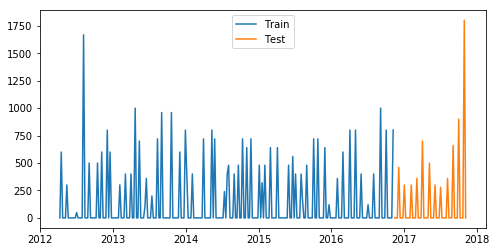

In [81]:
# plot one item
from functions import plot_train_test
plot_train_test(train_df, test_df, '8758-1')

In [89]:
# make a df to store all our predictions
from functions import make_copy_df
y_hat = make_copy_df(test_df, '8758-1')

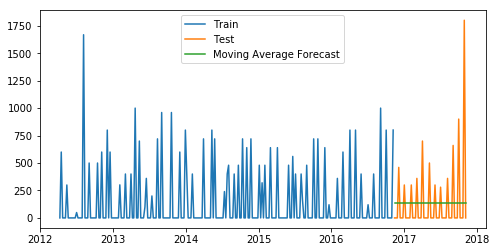

313.90930737147295

In [90]:
# baseline: Moving Average with 52
from functions import moving_average
from functions import plot_time_series
from functions import RMSE

y_hat['moving_avg'] = moving_average(train_df['8758-1'], m=52)

plot_time_series(train_df, test_df, '8758-1', y_hat, 'moving_avg', 'Moving Average Forecast')

RMSE(test_df,'8758-1', y_hat, 'moving_avg')

In [93]:
# SARIMA
# gridsearch with pyramid
from pyramid.arima import ARIMA

fit = ARIMA(order=(1, 1, 0), seasonal_order=(1, 0, 0, 12)).fit(y=train_df['8758-1'])

from pyramid.arima import auto_arima

stepwise_fit = auto_arima(train_df['8758-1'], start_p=0, start_q=0, max_p=6, max_q=6, m=12,
                          start_P=0, seasonal=True, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=3443.308, BIC=3453.583, Fit time=0.307 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=3587.826, BIC=3594.675, Fit time=0.016 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=3458.893, BIC=3472.592, Fit time=0.334 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3254.663, BIC=3268.363, Fit time=0.577 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=3254.542, BIC=3271.666, Fit time=0.945 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=3333.273, BIC=3346.973, Fit time=0.398 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=3390.571, BIC=3400.846, Fit time=0.096 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=3252.388, BIC=3276.363, Fit time=3.300 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_orde

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  240
Model:             SARIMAX(3, 1, 1)x(2, 1, 1, 12)   Log Likelihood               -1608.362
Date:                            Mon, 04 Jun 2018   AIC                           3234.724
Time:                                    13:23:25   BIC                           3265.549
Sample:                                         0   HQIC                          3247.163
                                            - 240                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0569      0.151     -0.378      0.706      -0.353       0.239
ar.L1         -0.2870      0.094     -3.048      0.002      -0.472      -0.102
ar.L2         -0.2161      0.091     -2.367      0.018      -0.395      -0.037
ar.L3         -0.1126      0.068     -1.653      0.098      -0.246       0.021
ma.L1         -1.0000      0.098    -10.184      0.000      -1.192      -0.808
ar.S.L12      -0.2126      0.069     -3.102      0.002      -0.347      -0.078
ar.S.L24      -0.1972      0.069     -2.838      0.005      -0.333      -0.061
ma.S.L12      -0.8639      0.077    -11.203      0.000      -1.015      -0.713
sigma2      7.289e+04   1.35e-06   5.41e+10      0.000    7.29e+04    7.29e+04
===================================================================================
Ljung-Box (Q):                       37.85   Jarque-Bera (JB):                53.48
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                             0.99
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.29e+26. Standard errors may be unstable.
"""

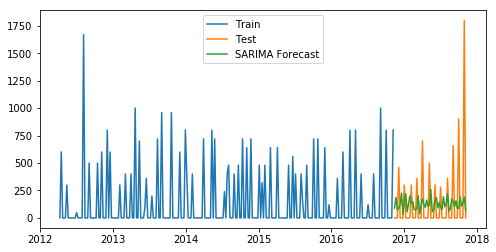

309.99155737132344

In [94]:
# fit with SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX

fit1 = SARIMAX(train_df['8758-1'], order=(3, 1, 1), seasonal_order=(2,1,1,12), freq='W').fit()
y_hat['SARIMA'] = fit1.predict(start="2016-11-06", end="2017-11-05", dynamic=True, typ='levels')

# plot
plot_time_series(train_df, test_df, '8758-1', y_hat, 'SARIMA', 'SARIMA Forecast')

# calculate RMSE

RMSE(test_df,'8758-1', y_hat, 'SARIMA')

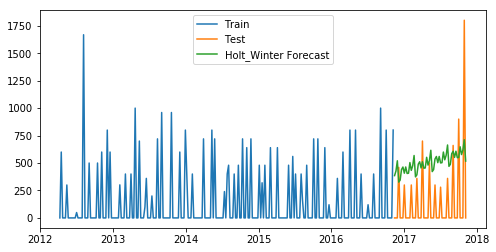

478.1231087078836

In [92]:
# Holt-Winters
# here we have trend and seasonality, so we will use Holt-Winters with Statsmodels
# additive trend and seasonality, no trend damping, seasonal periods=12
import numpy as np
from statsmodels.tsa.api import ExponentialSmoothing

fit1 = ExponentialSmoothing(np.asarray(train_df['8758-1']), seasonal_periods=12, 
                            trend='additive', seasonal='additive').fit(smoothing_level=0.51, 
                                                             smoothing_slope=0.015,
                                                             smoothing_seasonal=0.1)
y_hat['Holt_Winter'] = fit1.forecast(len(test_df))

# plot
plot_time_series(train_df, test_df, '8758-1', y_hat, 'Holt_Winter', 'Holt_Winter Forecast')

# calculate RMSE
RMSE(test_df,'8758-1', y_hat, 'Holt_Winter')

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/andreafabry/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


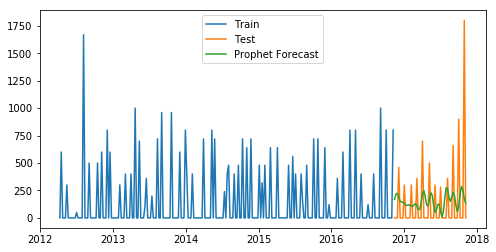

315.48744827814534

In [91]:
# FB Prophet
# imports 
from fbprophet import Prophet

# make a copy of the dataframe for Prophet transformations
from functions import make_copy_df
prophet_df = make_copy_df(train_df, '8758-1')

# rename variables (prophet requires the variable names in the time series to be
# y for target and ds for Datetime)
from functions import rename_columns
rename_columns(prophet_df, '8758-1')

# instantiate model instance and set the uncertainty interval to 95% 
# (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95, weekly_seasonality=True)
# fit
my_model.fit(prophet_df)
# forecast for a year
future_dates = my_model.make_future_dataframe(periods=52, freq='W')
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast = forecast.set_index('ds')
forecast_slice=forecast[240:292]
forecast_df = forecast_slice["yhat"]
# plot
plot_time_series(train_df, test_df, '8758-1', forecast_slice, 'yhat', 'Prophet Forecast')

RMSE(test_df, '8758-1', forecast_slice, 'yhat')

### product_type5

In [95]:
product_type5

['03138500FC',
 '0313FC320',
 '0314FT320-2',
 '1555',
 '1605',
 '1608',
 '1700',
 '2263',
 '2265',
 '2267',
 '2267-4',
 '2843',
 '2922',
 '3702',
 '3982-7/16',
 '3982-7/20',
 '3983-7',
 '4001-7',
 '4003-7',
 '4010-7/07',
 '4022',
 '4034-7',
 '4040-7/12',
 '4040/09',
 '4045',
 '4050',
 '4051r',
 '4052r',
 '4066/12',
 '40664-7/12',
 '4068',
 '4101-7',
 '4105',
 '4106-7',
 '4109',
 '4110',
 '4114-7/16',
 '4114-7/20',
 '4121-7',
 '4124-7',
 '4125-7',
 '4136-7',
 '4145-7',
 '4149',
 '4149-7',
 '4151-7',
 '4158-7',
 '4166-7/20',
 '4173-7',
 '4175-7',
 '4183',
 '4196-7',
 '4463/23',
 '4483',
 '4493/32',
 '4504-7/23',
 '4522-7/20',
 '4522/20',
 '4523-7/14',
 '4572-7/16',
 '4576-7/20',
 '4582-7/12',
 '4582-7/26',
 '4582/20',
 '4584-7/20',
 '4585-7/16',
 '4585-7/20',
 '4585/20',
 '4602',
 '4603-7',
 '4606-7/14',
 '4622WS',
 '4625WS',
 '4625WSCAB',
 '4627WS',
 '4628WS',
 '4732',
 '4852-7/16',
 '4854-7',
 '4855-7',
 '4856-7',
 '4857-7/28',
 '4858-7',
 '4859-7/28',
 '5500',
 '5501',
 '5558-1-100',


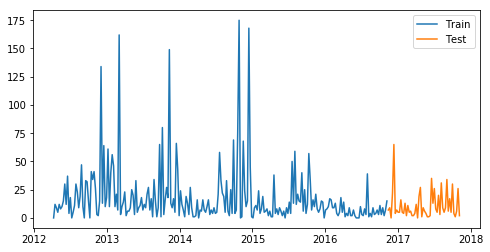

In [97]:
# plot one item
from functions import plot_train_test
plot_train_test(train_df, test_df, '2267')

# make a df to store all our predictions
from functions import make_copy_df
y_hat = make_copy_df(test_df, '2267')

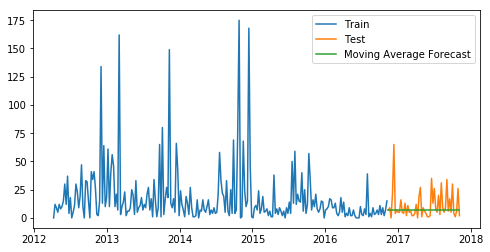

12.621114435175636

In [98]:
# baseline: Moving Average with 52
from functions import moving_average
from functions import plot_time_series
from functions import RMSE

y_hat['moving_avg'] = moving_average(train_df['2267'], m=52)

plot_time_series(train_df, test_df, '2267', y_hat, 'moving_avg', 'Moving Average Forecast')

RMSE(test_df,'2267', y_hat, 'moving_avg')

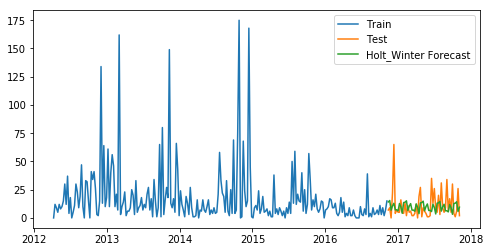

13.001151410430074

In [99]:
# Holt-Winters
# here we have trend and seasonality, so we will use Holt-Winters with Statsmodels
# additive trend and seasonality, no trend damping, seasonal periods=12
import numpy as np
from statsmodels.tsa.api import ExponentialSmoothing

fit1 = ExponentialSmoothing(np.asarray(train_df['2267']), seasonal_periods=12, 
                            trend='additive', seasonal='additive').fit(smoothing_level=0.51, 
                                                             smoothing_slope=0.015,
                                                             smoothing_seasonal=0.1)
y_hat['Holt_Winter'] = fit1.forecast(len(test_df))

# plot
plot_time_series(train_df, test_df, '2267', y_hat, 'Holt_Winter', 'Holt_Winter Forecast')

# calculate RMSE
RMSE(test_df,'2267', y_hat, 'Holt_Winter')

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/andreafabry/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


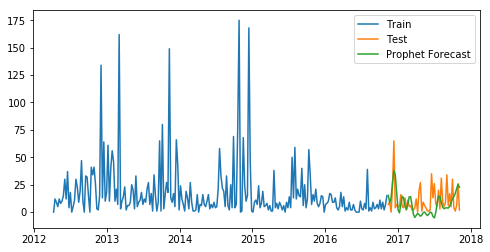

13.97740067109617

In [100]:
# FB Prophet
# imports 
from fbprophet import Prophet

# make a copy of the dataframe for Prophet transformations
from functions import make_copy_df
prophet_df = make_copy_df(train_df, '2267')

# rename variables (prophet requires the variable names in the time series to be
# y for target and ds for Datetime)
from functions import rename_columns
rename_columns(prophet_df, '2267')

# instantiate model instance and set the uncertainty interval to 95% 
# (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95, weekly_seasonality=True)
# fit
my_model.fit(prophet_df)
# forecast for a year
future_dates = my_model.make_future_dataframe(periods=52, freq='W')
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast = forecast.set_index('ds')
forecast_slice=forecast[240:292]
forecast_df = forecast_slice["yhat"]
# plot
plot_time_series(train_df, test_df, '2267', forecast_slice, 'yhat', 'Prophet Forecast')

RMSE(test_df, '2267', forecast_slice, 'yhat')

In [101]:
# SARIMA
# gridsearch with pyramid
from pyramid.arima import ARIMA

fit = ARIMA(order=(1, 1, 0), seasonal_order=(1, 0, 0, 12)).fit(y=train_df['2267'])

from pyramid.arima import auto_arima

stepwise_fit = auto_arima(train_df['2267'], start_p=0, start_q=0, max_p=6, max_q=6, m=12,
                          start_P=0, seasonal=True, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=2311.315, BIC=2321.590, Fit time=0.325 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=2464.327, BIC=2471.177, Fit time=0.015 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=2329.606, BIC=2343.305, Fit time=0.287 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2169.620, BIC=2183.320, Fit time=1.088 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=2171.675, BIC=2188.800, Fit time=0.408 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=2300.367, BIC=2310.642, Fit time=0.172 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=2171.481, BIC=2188.606, Fit time=2.381 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=2172.226, BIC=2192.775, Fit time=2.918 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2171.756, BIC=2188.881, Fit time=0.400 seconds
Fit ARIMA: order=(0, 1, 2) s

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  240
Model:             SARIMAX(0, 1, 4)x(0, 1, 1, 12)   Log Likelihood               -1076.402
Date:                            Mon, 04 Jun 2018   AIC                           2166.804
Time:                                    13:30:10   BIC                           2190.779
Sample:                                         0   HQIC                          2176.478
                                            - 240                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0265      0.088     -0.301      0.764      -0.199       0.146
ma.L1         -0.9699      0.046    -21.232      0.000      -1.059      -0.880
ma.L2         -0.0069      0.073     -0.094      0.925      -0.150       0.136
ma.L3          0.0321      0.086      0.374      0.708      -0.136       0.201
ma.L4          0.1351      0.062      2.178      0.029       0.014       0.257
ma.S.L12      -0.9962      1.831     -0.544      0.586      -4.586       2.593
sigma2       655.4375   1181.128      0.555      0.579   -1659.531    2970.406
===================================================================================
Ljung-Box (Q):                       33.91   Jarque-Bera (JB):               886.09
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               0.25   Skew:                             2.00
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

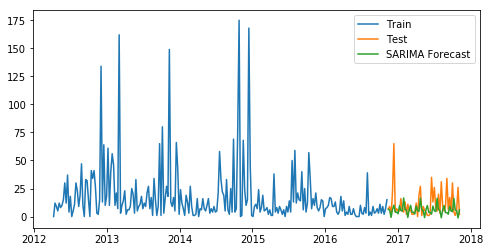

13.774458040627602

In [102]:
# fit with SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX

fit1 = SARIMAX(train_df['2267'], order=(0, 1, 4), seasonal_order=(0,1,1,12), freq='W').fit()
y_hat['SARIMA'] = fit1.predict(start="2016-11-06", end="2017-11-05", dynamic=True, typ='levels')

# plot
plot_time_series(train_df, test_df, '2267', y_hat, 'SARIMA', 'SARIMA Forecast')

# calculate RMSE

RMSE(test_df,'2267', y_hat, 'SARIMA')